# **Time Series Analysis from COVID19 API**

---



By: *Kyle W. Brown*

Original example can be found here:

https://www.tensorflow.org/tutorials/structured_data/time_series




In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# POST to API
payload = {'code': 'US'} # or {'code': 'DE'}
URL = 'https://api.statworx.com/covid'
response = requests.post(url=URL, data=json.dumps(payload))

# Convert to data frame
df = pd.DataFrame.from_dict(json.loads(response.text))

In [0]:

df.head()

,date,day,month,year,cases,deaths,country,code,population,cases_cum,deaths_cum
0,2019-12-31,31,12,2019,0,0,United_States_of_America,US,327167434,0,0
1,2020-01-01,1,1,2020,0,0,United_States_of_America,US,327167434,0,0
2,2020-01-02,2,1,2020,0,0,United_States_of_America,US,327167434,0,0
3,2020-01-03,3,1,2020,0,0,United_States_of_America,US,327167434,0,0
4,2020-01-04,4,1,2020,0,0,United_States_of_America,US,327167434,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99,2020-04-08,8,4,2020,30613,1906,United_States_of_America,US,327167434,398809,12895
100,2020-04-09,9,4,2020,33323,1922,United_States_of_America,US,327167434,432132,14817
101,2020-04-10,10,4,2020,33901,1873,United_States_of_America,US,327167434,466033,16690
102,2020-04-11,11,4,2020,35527,2087,United_States_of_America,US,327167434,501560,18777


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    #Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 74

In [0]:
tf.random.set_random_seed(13)

In [0]:
uni_data = df['cases_cum']
uni_data.index = df['date']
uni_data.head()

date
2019-12-31    0
2020-01-01    0
2020-01-02    0
2020-01-03    0
2020-01-04    0
Name: cases_cum, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff79e3c4cf8>],
      dtype=object)

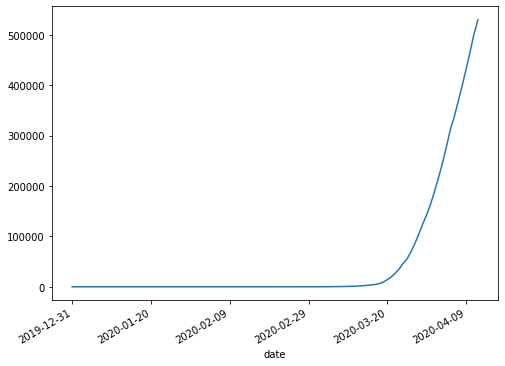

In [0]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target cumulative confirmed to predict')
print (y_train_uni[0])

Single window of past history
[[-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]
 [-0.35604638]]

 Target cumulative confirmed to predict
-0.3560463830477833


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

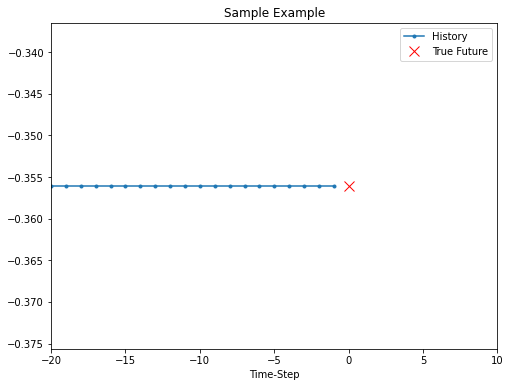

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

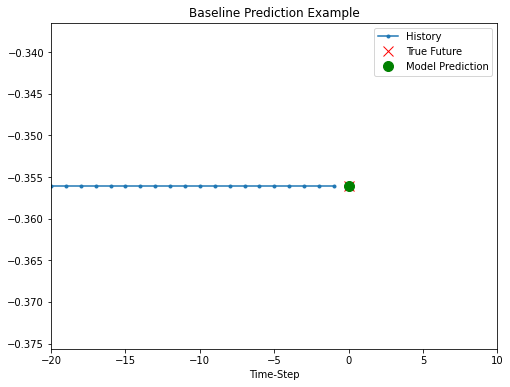

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [0]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(10, 1)


In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 15s 77ms/step - loss: 0.3649 - val_loss: 1347.2683
Epoch 2/10
200/200 [==============================] - 11s 53ms/step - loss: 0.1240 - val_loss: 1346.1501
Epoch 3/10
200/200 [==============================] - 10s 50ms/step - loss: 0.0522 - val_loss: 1346.4072
Epoch 4/10
200/200 [==============================] - 11s 53ms/step - loss: 0.0339 - val_loss: 1346.1277
Epoch 5/10
200/200 [==============================] - 10s 51ms/step - loss: 0.0262 - val_loss: 1345.7711
Epoch 6/10
200/200 [==============================] - 11s 55ms/step - loss: 0.0216 - val_loss: 1345.9177
Epoch 7/10
200/200 [==============================] - 10s 50ms/step - loss: 0.0190 - val_loss: 1345.8490
Epoch 8/10
200/200 [==============================] - 10s 52ms/step - loss: 0.0176 - val_loss: 1345.8533
Epoch 9/10
200/200 [==============================] - 10s 50ms/step - loss: 0.0170 - val_loss: 1345.8651
Epoch 10/10


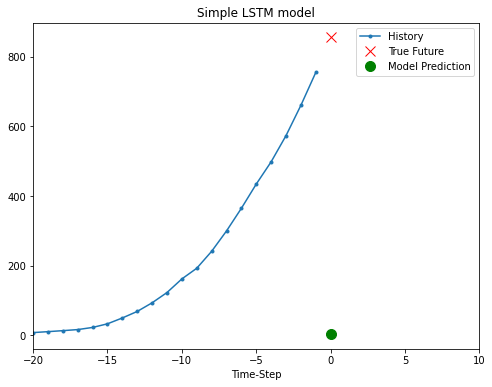

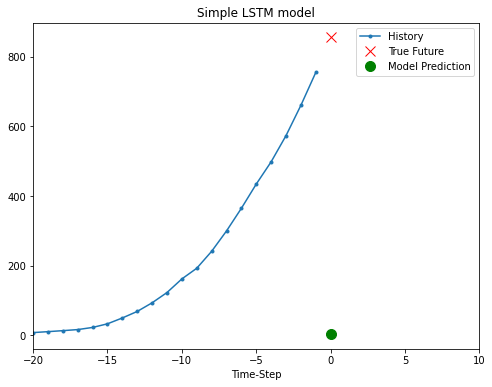

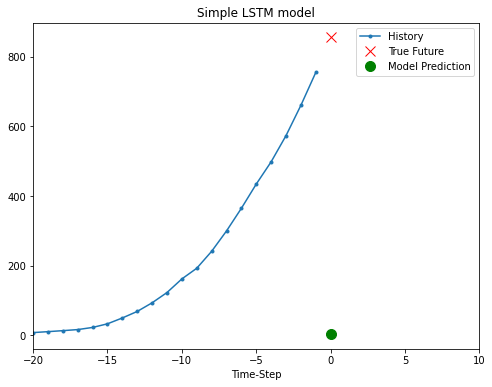

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [0]:
features_considered = ['cases_cum', 'deaths_cum']

In [0]:
features = df[features_considered]
features.index = df['date']
features.head()

,cases_cum,deaths_cum
date,,
2019-12-31,0,0
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff71761ac50>,
      dtype=object)

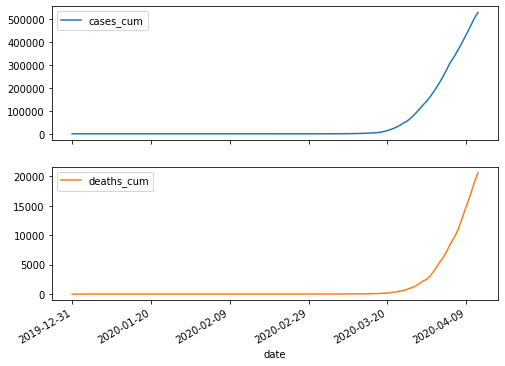

In [0]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 10
future_target = 5
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [0]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 2)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [0]:
initial = np.loadtxt(filename).astype(np.float32)

for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

TypeError: ignored

In [0]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [0]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [0]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [0]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [0]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [0]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

In [0]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [0]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])